In [1]:
# Power Outage Prediction Model
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import dask.dataframe as dd


In [2]:

## 1. Data Loading with Proper Column Handling

# Load Eaglei outages (using Dask for large dataset)
eaglei = dd.read_csv('/home/adelechinda/home/projects/powerup/data/eaglei_outages.csv', 
                    dtype={'fips_code': 'int32',
                           'county': 'object',
                           'state': 'object',
                           'sum': 'float32',
                           'run_start_time': 'object'})


In [3]:

# Create date column from run_start_time
eaglei['date'] = dd.to_datetime(eaglei['run_start_time']).dt.date

# Aggregate outages by county and date
outage_events = eaglei.groupby(['fips_code', 'county', 'state', 'date'])\
                      .agg({'sum': 'sum'})\
                      .rename(columns={'sum': 'outage_duration'})\
                      .compute()


/home/adelechinda/miniconda3/envs/powerup_env/lib/python3.12/site-packages/dask/dataframe/dask_expr/_expr.py:1522: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return get_meta_library(args[0]).to_datetime(*args, **kwargs)


In [4]:

# Create binary target (1 if outage occurred)
outage_events['outage_occurred'] = (outage_events['outage_duration'] > 0).astype(int)


In [5]:

# Load VTEC data with proper datetime handling
vtec = pd.read_csv('/home/adelechinda/home/projects/powerup/data/vtec.csv', parse_dates=['ISSUED'])
vtec['date'] = vtec['ISSUED'].dt.date


/tmp/ipykernel_967488/2171361843.py:2: DtypeWarning: Columns (10,13,14,18,19,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  vtec = pd.read_csv('/home/adelechinda/home/projects/powerup/data/vtec.csv', parse_dates=['ISSUED'])


In [6]:

# Create weather event features
vtec_features = vtec.groupby(['WFO', 'date']).agg({
    'WINDTAG': 'max',
    'HAILTAG': 'max',
    'IS_EMERGENCY': 'sum',
    'PHENOM': lambda x: x.str.contains('Wind').sum()
}).rename(columns={'PHENOM': 'wind_events'}).reset_index()


In [7]:

# Load NOAA data with proper datetime handling
noaa = pd.read_csv('/home/adelechinda/home/projects/powerup/data/noaa.csv', parse_dates=['BGN_DATE'], encoding="ISO-8859-1")
noaa['date'] = noaa['BGN_DATE'].dt.date


/tmp/ipykernel_967488/191022500.py:2: DtypeWarning: Columns (2,9,10,11,12,16,17,27,28,29,30,35) have mixed types. Specify dtype option on import or set low_memory=False.
  noaa = pd.read_csv('/home/adelechinda/home/projects/powerup/data/noaa.csv', parse_dates=['BGN_DATE'], encoding="ISO-8859-1")


In [8]:

# Create severity features from NOAA
noaa_features = noaa.groupby(['STATE', 'COUNTYNAME', 'date']).agg({
    'MAG': 'max',
    'FATALITIES': 'sum',
    'INJURIES': 'sum',
    'EVTYPE': lambda x: x.str.contains('Storm').sum()
}).rename(columns={'EVTYPE': 'storm_events'}).reset_index()


In [9]:

## 2. Safe Data Merging

# First merge: outages with VTEC (state-level)
merged_data = pd.merge(
    outage_events.reset_index(),
    vtec_features,
    left_on=['state', 'date'],
    right_on=['WFO', 'date'],
    how='left'
)


In [10]:

# Second merge: add NOAA data (county-level)
final_data = pd.merge(
    merged_data,
    noaa_features,
    left_on=['state', 'county', 'date'],
    right_on=['STATE', 'COUNTYNAME', 'date'],
    how='left'
)


In [11]:

# Clean up merged data
final_data.fillna({
    'WINDTAG': 0,
    'HAILTAG': 0,
    'IS_EMERGENCY': 0,
    'wind_events': 0,
    'MAG': 0,
    'FATALITIES': 0,
    'INJURIES': 0,
    'storm_events': 0
}, inplace=True)


In [12]:

## 3. Feature Engineering

# Temporal features
final_data['date'] = pd.to_datetime(final_data['date'])
final_data['day_of_year'] = final_data['date'].dt.dayofyear
final_data['month'] = final_data['date'].dt.month
final_data['is_weekend'] = final_data['date'].dt.dayofweek.isin([5,6]).astype(int)


In [13]:

# Weather severity composite
final_data['weather_severity'] = (
    final_data['WINDTAG'] + 
    final_data['HAILTAG'] + 
    final_data['MAG'] +
    final_data['IS_EMERGENCY'] * 2
)


In [14]:

# Encode categorical variables
for col in ['state', 'county', 'WFO']:
    le = LabelEncoder()
    final_data[col] = le.fit_transform(final_data[col].astype(str))


In [15]:

## 4. Model Training

# Select features and target
features = [
    'WINDTAG', 'HAILTAG', 'IS_EMERGENCY', 'wind_events',
    'MAG', 'FATALITIES', 'INJURIES', 'storm_events',
    'day_of_year', 'month', 'is_weekend', 'weather_severity'
]
X = final_data[features]
y = final_data['outage_occurred']


In [16]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:

# Train Random Forest
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10, n_jobs=-1,
                       random_state=42)

In [18]:

# Evaluate
predictions = model.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))


Model Accuracy: 0.6139103713742389

Classification Report:
               precision    recall  f1-score   support

           0       0.09      0.55      0.15     69700
           1       0.95      0.62      0.75   1039343

    accuracy                           0.61   1109043
   macro avg       0.52      0.58      0.45   1109043
weighted avg       0.90      0.61      0.71   1109043



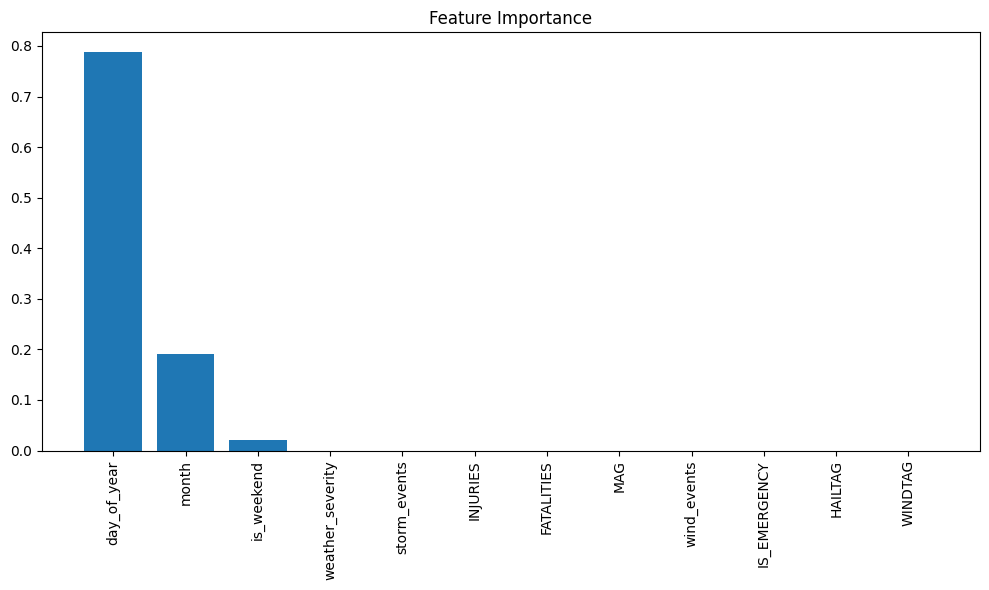

In [19]:

## 5. Feature Importance
import matplotlib.pyplot as plt

importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), importances[sorted_idx], align='center')
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=90)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()